In [1]:
import nltk
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                7593 non-null   object 
 1   target              7593 non-null   int64  
 2   text_norm           7593 non-null   object 
 3   stemmed_keyword     7593 non-null   object 
 4   disaster_asc_coeff  7593 non-null   float64
 5   length_norm         7593 non-null   int64  
 6   neg                 7593 non-null   float64
 7   neu                 7593 non-null   float64
 8   pos                 7593 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 534.0+ KB


For this part we will only used the normalized text, disaster association coefficient and the length of the normalized text and drop all other columns.

In [4]:
df_train.drop(['text', 'stemmed_keyword', 'neg', 'neu', 'pos'], axis = 1, inplace = True)

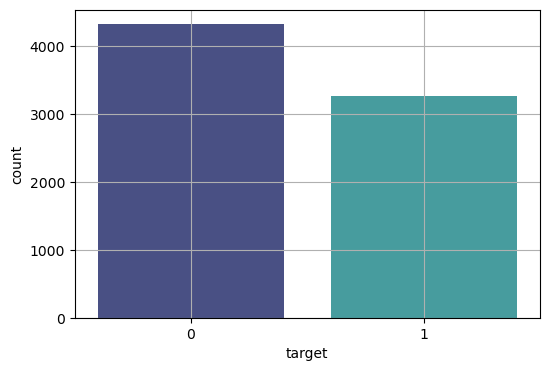

In [5]:
# let's look at distribution of the target variable
plt.figure(figsize = (6,4))
sns.countplot(data = df_train, x = 'target', palette = "mako")
plt.grid()

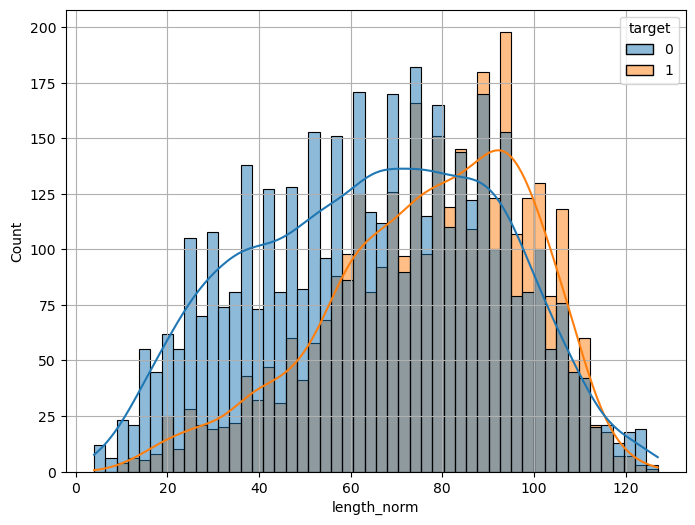

In [6]:
# check target variable distribution with respect to length
plt.figure(figsize = (8,6))
sns.histplot(df_train, x = 'length_norm', hue = 'target', bins = 50, kde = True)
plt.grid()

### Count Vectorization of Text String

#### Bag of words model



The bag of words model first uses the entire text dataset to create a vocabulary of tokens. Then for each text data point, a count vector is created that contains the number of times each token is present in the dataset. This will be a very sparse matrix for most text dataset.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
df_train.head()

,target,text_norm,disaster_asc_coeff,length_norm
0,1,deed reason earthquak may allah forgiv us,0.785714,41
1,1,forest fire near la rong sask canada,0.386364,36
2,1,resid ask shelter place notifi offic evacu she...,0.767241,69
3,1,13000 peopl receiv wildfir evacu order california,0.767241,49
4,1,got sent photo rubi alaska smoke wildfir pour ...,0.386364,52


In [9]:
complete_vocab = df_train['text_norm']

In [10]:
complete_vocab

0               deed reason earthquak may allah forgiv us
1                    forest fire near la rong sask canada
2       resid ask shelter place notifi offic evacu she...
3       13000 peopl receiv wildfir evacu order california
4       got sent photo rubi alaska smoke wildfir pour ...
                              ...                        
7588    two giant crane hold bridg collaps nearbi home...
7589    ariaahrari thetawniest control wild fire calif...
7590    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7591    polic investig ebik collid car littl portug eb...
7592    latest home raze northern california wildfir a...
Name: text_norm, Length: 7593, dtype: object

In [11]:
from nltk.tokenize import word_tokenize

In [12]:
# create a bag of words transformer using word_tokenize as the analyzer as the text has already been normalized
bow_transformer = CountVectorizer(analyzer = word_tokenize).fit(complete_vocab)

In [13]:
# check how large the vocabulary is
print(len(bow_transformer.vocabulary_))

19542


In [14]:
tweet2 = df_train['text_norm'][2]
print(tweet2)

resid ask shelter place notifi offic evacu shelter place order expect


In [15]:
# each term is converted into it's vocabulary id and the count
print(bow_transformer.transform([tweet2]))

  (0, 1453)	1
  (0, 4785)	1
  (0, 4850)	1
  (0, 13957)	1
  (0, 14096)	1
  (0, 14266)	1
  (0, 14744)	2
  (0, 15574)	1
  (0, 16382)	2


In [16]:
# create the sparse matrix using normaized text and stemmed keyword
tweets_bow = bow_transformer.transform(df_train['text_norm'])

In [17]:
tweets_bow.shape

(7593, 19542)

In [18]:
#to get non zero occurence
tweets_bow.nnz

74352

In [19]:
def get_sparsity(matrx):
    total_elements = (matrx.shape[0] * matrx.shape[1])
    total_nonzero = matrx.nnz
    total_zero = total_elements - total_nonzero
    sparsity = total_zero/total_elements
    return 100*sparsity

In [20]:
# check sparsity
print(f'sparsity: {get_sparsity(tweets_bow):.3f}%')

sparsity: 99.950%


### Tf-idf weighing

**Tf** also known as **term frequency** is the number of times a term occurs in a specific text data point.
**df** also known as **document frequency** is the number of documents the term occurs in. The lower the **df**, the rarer the term
**idf** also known as the **inverse document frequency** quantifies a term's rarity using its **df** value. Lower **df** corresponds to higher **idf**.

### Tf-idf weight = Tf x idf is an attibute of a single datapoint with regards to a single term
1. We will now convert the count matrix into a tf-idf weight matrix. 
2. This whole process has converted out text data into numerical data existing in  avector space where each token in the bag of words vocabulary is a dimension. 
3. After that, any new data text data can be converted to a tf-idf vector and has it's own position in the vector space.
4. Depending on where the new data lies, we can classify it as "disaster" or "non-disaster" tweet.

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

In [22]:
#creating tfidf transformer
tfidf_transformer = TfidfTransformer().fit(tweets_bow)

In [23]:
#let's see the tf-idf for third_BOW

tfidf_third = tfidf_transformer.transform(tweets_bow[3])

In [24]:
print(tfidf_third)

  (0, 18973)	0.32814001393259234
  (0, 15402)	0.49525962845718413
  (0, 14582)	0.27763551127566677
  (0, 14266)	0.3730684000057852
  (0, 4785)	0.30237137333620445
  (0, 2549)	0.3067082921601925
  (0, 140)	0.49525962845718413


In [25]:
#converting sparse matrix data to tfidf values

tweets_tfidf = tfidf_transformer.transform(tweets_bow)

In [26]:
print(tweets_tfidf.shape)

(7593, 19542)


In [27]:
type(tweets_tfidf)

scipy.sparse._csr.csr_matrix

Create final training feature set from the tf-idf array and other remaining features

In [28]:
# convert sparse array to dense numpy arrar and then to datafraame
df_final = pd.DataFrame(tweets_tfidf.toarray())
df_final

,0,1,2,3,4,5,6,7,8,9,...,19532,19533,19534,19535,19536,19537,19538,19539,19540,19541
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428477,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# normalize 'length_norm' column
from sklearn.preprocessing import MinMaxScaler

In [30]:
mc = MinMaxScaler()

In [31]:
df_train['length_norm_std'] = mc.fit_transform((np.array(df_train['length_norm'])).reshape(-1,1))

At this point we will create two sets of training data, one containing only tfidf values and another one with the attributes 'disaster_asc_coeff' and 'length_norm_std' in addition to the tfidf values.

In [32]:
df_tfidf_only = df_final.copy()
df_all_atrib = pd.concat([df_final, df_train[['disaster_asc_coeff', 'length_norm_std']]], axis = 1)

### Training on tfidf values + additional attributes

In [33]:
df_all_atrib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Columns: 19544 entries, 0 to length_norm_std
dtypes: float64(19544)
memory usage: 1.1 GB


In [34]:
df_all_atrib.head()

,0,1,2,3,4,5,6,7,8,9,...,19534,19535,19536,19537,19538,19539,19540,19541,disaster_asc_coeff,length_norm_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785714,0.300813
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386364,0.260163
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.767241,0.528455
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.767241,0.365854
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386364,0.390244


In [35]:
df_all_atrib.columns = df_all_atrib.columns.astype(str)
df_all_atrib.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19534', '19535', '19536', '19537', '19538', '19539', '19540', '19541',
       'disaster_asc_coeff', 'length_norm_std'],
      dtype='object', length=19544)

### Train Test Split

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
# drop all columns except 'association coefficient' and those related to sentiment analysis
X = df_all_atrib
y = df_train['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [39]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,19534,19535,19536,19537,19538,19539,19540,19541,disaster_asc_coeff,length_norm_std
6894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151515,0.455285
2337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257143,0.658537
1798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.739837
7096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.787879,0.455285
5038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529412,0.292683


In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087 entries, 6894 to 179
Columns: 19544 entries, 0 to length_norm_std
dtypes: float64(19544)
memory usage: 758.6 MB


### Model Selection
As the data has a lot of dimensions now, using certain type of parametric models ca be quite expensive. In addition, since the data is so sparse in most dimensions, euclidean distance may not be the best metric to calculate similarity between two datapoints. Therefore, we will use cosine similarity as the metric.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

### 1) KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn_model = KNeighborsClassifier(metric = 'cosine', weights = 'uniform')

In [44]:
# using grid search CV for cross validation
from sklearn.model_selection import GridSearchCV

# since out matrix is sparse we need to use larger k
random_grid = {
    'n_neighbors': [50, 70, 100, 120, 150, 200, 250, 300, 350, 400, 450, 500]
}

In [45]:
knn_cv = GridSearchCV(estimator = knn_model, param_grid = random_grid,
                               cv = 10, verbose = 2)
knn_cv.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END .....................................n_neighbors=50; total time=  23.2s
[CV] END .....................................n_neighbors=50; total time=  14.1s
[CV] END .....................................n_neighbors=50; total time=   7.4s
[CV] END .....................................n_neighbors=50; total time=   9.6s
[CV] END .....................................n_neighbors=50; total time=   9.8s
[CV] END .....................................n_neighbors=50; total time=   9.5s
[CV] END .....................................n_neighbors=50; total time=   9.3s
[CV] END .....................................n_neighbors=50; total time=   9.8s
[CV] END .....................................n_neighbors=50; total time=  10.2s
[CV] END .....................................n_neighbors=50; total time=   9.9s
[CV] END .....................................n_neighbors=70; total time=   9.4s
[CV] END .....................................

[CV] END ....................................n_neighbors=450; total time=   4.5s
[CV] END ....................................n_neighbors=450; total time=   4.5s
[CV] END ....................................n_neighbors=450; total time=   4.5s
[CV] END ....................................n_neighbors=450; total time=   4.4s
[CV] END ....................................n_neighbors=450; total time=   4.5s
[CV] END ....................................n_neighbors=450; total time=   4.5s
[CV] END ....................................n_neighbors=450; total time=   4.4s
[CV] END ....................................n_neighbors=450; total time=   4.8s
[CV] END ....................................n_neighbors=450; total time=   4.4s
[CV] END ....................................n_neighbors=500; total time=   4.5s
[CV] END ....................................n_neighbors=500; total time=   4.3s
[CV] END ....................................n_neighbors=500; total time=   4.3s
[CV] END ...................

GridSearchCV(cv=10, estimator=KNeighborsClassifier(metric='cosine'),
             param_grid={'n_neighbors': [50, 70, 100, 120, 150, 200, 250, 300,
                                         350, 400, 450, 500]},
             verbose=2)

In [46]:
# save best parameters
params = knn_cv.best_params_
params

{'n_neighbors': 50}

In [47]:
params['metric'] = 'cosine'
params['weights'] = 'uniform'

In [48]:
knn_final = KNeighborsClassifier(**params)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=50)

In [49]:
# get predictions
y_pred = knn_final.predict(X_test)

In [50]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[666 767]
 [112 961]]
              precision    recall  f1-score   support

           0       0.86      0.46      0.60      1433
           1       0.56      0.90      0.69      1073

    accuracy                           0.65      2506
   macro avg       0.71      0.68      0.64      2506
weighted avg       0.73      0.65      0.64      2506



### 2) SVM

In [51]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
svc_model = SVC(kernel = cosine_similarity)

In [53]:
C_list = (np.linspace(0.01, 10, 25)).tolist()

random_grid = {
    'C': C_list,
    'gamma': ['scale', 'auto']
}

In [54]:
svc_cv = GridSearchCV(estimator = svc_model, param_grid = random_grid,
                               cv = 5, verbose = 2)
svc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................................C=0.01, gamma=scale; total time=  17.8s
[CV] END ................................C=0.01, gamma=scale; total time=  14.7s
[CV] END ................................C=0.01, gamma=scale; total time=  15.6s
[CV] END ................................C=0.01, gamma=scale; total time=  15.3s
[CV] END ................................C=0.01, gamma=scale; total time=  15.2s
[CV] END .................................C=0.01, gamma=auto; total time=  15.0s
[CV] END .................................C=0.01, gamma=auto; total time=  14.8s
[CV] END .................................C=0.01, gamma=auto; total time=  17.1s
[CV] END .................................C=0.01, gamma=auto; total time=  15.0s
[CV] END .................................C=0.01, gamma=auto; total time=  17.9s
[CV] END .............................C=0.42625, gamma=scale; total time=  15.0s
[CV] END .............................C=0.42625

[CV] END ...................C=4.172499999999999, gamma=scale; total time=  33.8s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  33.5s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  33.6s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  33.8s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  34.4s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  34.4s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.0s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  36.0s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.5s
[CV] END .............................C=4.58875, gamma=scale; total time=  35.7s
[CV] END .............................C=4.58875, gamma=scale; total time=  35.4s
[CV] END .............................C=4.58875, gamma=scale; total time=  35.7s
[CV] END ...................

[CV] END ...................C=8.334999999999999, gamma=scale; total time=  20.6s
[CV] END ...................C=8.334999999999999, gamma=scale; total time=  21.4s
[CV] END ....................C=8.334999999999999, gamma=auto; total time=  21.8s
[CV] END ....................C=8.334999999999999, gamma=auto; total time=  15.8s
[CV] END ....................C=8.334999999999999, gamma=auto; total time=  17.7s
[CV] END ....................C=8.334999999999999, gamma=auto; total time=  19.7s
[CV] END ....................C=8.334999999999999, gamma=auto; total time=  21.3s
[CV] END .............................C=8.75125, gamma=scale; total time=  20.0s
[CV] END .............................C=8.75125, gamma=scale; total time=  20.9s
[CV] END .............................C=8.75125, gamma=scale; total time=  19.2s
[CV] END .............................C=8.75125, gamma=scale; total time=  17.7s
[CV] END .............................C=8.75125, gamma=scale; total time=  17.3s
[CV] END ...................

GridSearchCV(cv=5,
             estimator=SVC(kernel=<function cosine_similarity at 0x00000148415A7880>),
             param_grid={'C': [0.01, 0.42625, 0.8425, 1.25875, 1.675,
                               2.0912499999999996, 2.5075, 2.92375, 3.34,
                               3.7562499999999996, 4.172499999999999, 4.58875,
                               5.005, 5.42125, 5.8375, 6.25375, 6.67, 7.08625,
                               7.5024999999999995, 7.91875, 8.334999999999999,
                               8.75125, 9.1675, 9.58375, 10.0],
                         'gamma': ['scale', 'auto']},
             verbose=2)

In [55]:
# save best parameters
params = svc_cv.best_params_
params

{'C': 1.675, 'gamma': 'scale'}

In [56]:
params['kernel'] = cosine_similarity

In [57]:
svc_final = SVC(**params)
svc_final.fit(X_train, y_train)

SVC(C=1.675, kernel=<function cosine_similarity at 0x00000148415A7880>)

In [58]:
# get predictions
y_pred = svc_final.predict(X_test)

In [59]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1192  241]
 [ 290  783]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1433
           1       0.76      0.73      0.75      1073

    accuracy                           0.79      2506
   macro avg       0.78      0.78      0.78      2506
weighted avg       0.79      0.79      0.79      2506



### Training on tfidf values only

In [60]:
df_tfidf_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Columns: 19542 entries, 0 to 19541
dtypes: float64(19542)
memory usage: 1.1 GB


In [61]:
df_tfidf_only.head()

,0,1,2,3,4,5,6,7,8,9,...,19532,19533,19534,19535,19536,19537,19538,19539,19540,19541
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
df_tfidf_only.columns = df_tfidf_only.columns.astype(str)
df_tfidf_only.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19532', '19533', '19534', '19535', '19536', '19537', '19538', '19539',
       '19540', '19541'],
      dtype='object', length=19542)

### Train Test Split

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
# drop all columns except 'association coefficient' and those related to sentiment analysis
X = df_tfidf_only
y = df_train['target']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [67]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,19532,19533,19534,19535,19536,19537,19538,19539,19540,19541
2662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087 entries, 2662 to 944
Columns: 19542 entries, 0 to 19541
dtypes: float64(19542)
memory usage: 758.5 MB


### Model Selection
As the data has a lot of dimensions now, using certain type of parametric models ca be quite expensive. In addition, since the data is so sparse in most dimensions, euclidean distance may not be the best metric to calculate similarity between two datapoints. Therefore, we will use cosine similarity as the metric.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

### 1) KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
knn_model = KNeighborsClassifier(metric = 'cosine')

In [72]:
# using grid search CV for cross validation
from sklearn.model_selection import GridSearchCV

# since out matrix is sparse we need to use larger k
random_grid = {
    'n_neighbors': [50, 70, 100, 120, 150, 200, 250, 300, 350, 400, 450, 500]
}

In [73]:
knn_cv = GridSearchCV(estimator = knn_model, param_grid = random_grid,
                               cv = 10, verbose = 2)
knn_cv.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END .....................................n_neighbors=50; total time=  16.6s
[CV] END .....................................n_neighbors=50; total time=  10.4s
[CV] END .....................................n_neighbors=50; total time=  11.4s
[CV] END .....................................n_neighbors=50; total time=  10.2s
[CV] END .....................................n_neighbors=50; total time=  10.0s
[CV] END .....................................n_neighbors=50; total time=   8.8s
[CV] END .....................................n_neighbors=50; total time=   9.2s
[CV] END .....................................n_neighbors=50; total time=   9.6s
[CV] END .....................................n_neighbors=50; total time=   9.7s
[CV] END .....................................n_neighbors=50; total time=   9.2s
[CV] END .....................................n_neighbors=70; total time=   8.7s
[CV] END .....................................

[CV] END ....................................n_neighbors=450; total time=   9.6s
[CV] END ....................................n_neighbors=450; total time=   9.9s
[CV] END ....................................n_neighbors=450; total time=   8.9s
[CV] END ....................................n_neighbors=450; total time=   9.4s
[CV] END ....................................n_neighbors=450; total time=   9.8s
[CV] END ....................................n_neighbors=450; total time=   9.7s
[CV] END ....................................n_neighbors=450; total time=   9.8s
[CV] END ....................................n_neighbors=450; total time=   9.6s
[CV] END ....................................n_neighbors=450; total time=   9.6s
[CV] END ....................................n_neighbors=500; total time=   9.7s
[CV] END ....................................n_neighbors=500; total time=   9.7s
[CV] END ....................................n_neighbors=500; total time=   9.8s
[CV] END ...................

GridSearchCV(cv=10, estimator=KNeighborsClassifier(metric='cosine'),
             param_grid={'n_neighbors': [50, 70, 100, 120, 150, 200, 250, 300,
                                         350, 400, 450, 500]},
             verbose=2)

In [74]:
# save best parameters
params = knn_cv.best_params_
params

{'n_neighbors': 70}

In [75]:
params['metric'] = 'cosine'

In [76]:
knn_final = KNeighborsClassifier(**params)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=70)

In [77]:
# get predictions
y_pred = knn_final.predict(X_test)

In [78]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1262  162]
 [ 421  661]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1424
           1       0.80      0.61      0.69      1082

    accuracy                           0.77      2506
   macro avg       0.78      0.75      0.75      2506
weighted avg       0.77      0.77      0.76      2506



### 2) SVM

In [79]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
svc_model = SVC(kernel = cosine_similarity)

In [81]:
C_list = (np.linspace(0.01, 10, 25)).tolist()

random_grid = {
    'C': C_list,
    'gamma': ['scale', 'auto']
}

In [ ]:
svc_cv = GridSearchCV(estimator = svc_model, param_grid = random_grid,
                               cv = 5, verbose = 2)
svc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................................C=0.01, gamma=scale; total time=  32.3s
[CV] END ................................C=0.01, gamma=scale; total time=  34.7s
[CV] END ................................C=0.01, gamma=scale; total time=  34.2s
[CV] END ................................C=0.01, gamma=scale; total time=  35.1s
[CV] END ................................C=0.01, gamma=scale; total time=  34.1s
[CV] END .................................C=0.01, gamma=auto; total time=  34.1s
[CV] END .................................C=0.01, gamma=auto; total time=  35.0s
[CV] END .................................C=0.01, gamma=auto; total time=  34.9s
[CV] END .................................C=0.01, gamma=auto; total time=  34.7s
[CV] END .................................C=0.01, gamma=auto; total time=  33.8s
[CV] END .............................C=0.42625, gamma=scale; total time=  35.3s
[CV] END .............................C=0.42625

[CV] END ...................C=4.172499999999999, gamma=scale; total time=  35.6s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  34.6s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  35.2s
[CV] END ...................C=4.172499999999999, gamma=scale; total time=  35.2s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  34.4s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.9s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.3s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.1s
[CV] END ....................C=4.172499999999999, gamma=auto; total time=  35.4s
[CV] END .............................C=4.58875, gamma=scale; total time=  35.7s
[CV] END .............................C=4.58875, gamma=scale; total time=  33.2s
[CV] END .............................C=4.58875, gamma=scale; total time=  35.3s
[CV] END ...................

In [ ]:
# save best parameters
params = svc_cv.best_params_
params

In [ ]:
params['kernel'] = cosine_similarity

In [ ]:
svc_final = SVC(**params)
svc_final.fit(X_train, y_train)

In [ ]:
# get predictions
y_pred = svc_final.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))